In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from repos_tools import read_chembl_screen_results, add_b3db_permeabilities
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!


The following SQL scripts extract from ChEMBL information on indications for each drug as well as standard InChi and canonical SMILES.

In [2]:
ls *.sql

drug-indication.sql                 drug_indication-complete-table.sql
drug-info.sql


Import the result of a network based ChEMBL screen

## BBB permeabilities

In [3]:
fpath = '../../results/2021-12-13-chembl-drug-info/drug-info.csv'
chembl_ids = pd.read_csv(fpath)
chembl_ids.columns

Index(['drug_chembl_id', 'drug_name', 'standard_inchi', 'canonical_smiles'], dtype='object')

In [4]:
fpath = '../../resources/B3DB/B3DB_classification.tsv'
dtypes = {'compound_name': 'str', 'IUPAC_name': 'str', 'SMILES': 'str', 'CID': np.float64, 'logBB': np.float64,
         'BBB+/BBB-': 'category', 'Inchi': 'str', 'group': 'category'}
b3db = pd.read_csv(fpath, sep='\t', dtype=dtypes)
b3db.columns

Index(['NO.', 'compound_name', 'IUPAC_name', 'SMILES', 'CID', 'logBB',
       'BBB+/BBB-', 'Inchi', 'threshold', 'reference', 'group', 'comments'],
      dtype='object')

In [5]:
chembl_bbb = pd.merge(left=chembl_ids, right=b3db, how='left', left_on='standard_inchi', right_on='Inchi')
chembl_bbb = chembl_bbb.drop(['canonical_smiles', 'NO.', 'compound_name', 'IUPAC_name', 'SMILES', 'CID', 'Inchi', 'threshold', 'reference', 'comments'], axis=1)
chembl_bbb = chembl_bbb.set_index('drug_chembl_id').rename({'group': 'BBB confidence group'}, axis=1)
bbb_path = '../../results/2021-12-13-chembl-drug-info/drug-info-bbb.csv'
chembl_bbb.to_csv(bbb_path, index=True)
chembl_bbb

,drug_name,standard_inchi,logBB,BBB+/BBB-,BBB confidence group
drug_chembl_id,,,,,
CHEMBL1000,CETIRIZINE,InChI=1S/C21H25ClN2O3/c22-19-8-6-18(7-9-19)21(...,NaN,BBB-,B
CHEMBL100116,PENTAZOCINE,InChI=1S/C19H27NO/c1-13(2)7-9-20-10-8-19(4)14(...,0.54,BBB+,A
CHEMBL1002,LEVOSALBUTAMOL,"InChI=1S/C13H21NO3/c1-13(2,3)14-7-12(17)9-4-5-...",NaN,NaN,NaN
CHEMBL100259,URIDINE,InChI=1S/C9H12N2O6/c12-3-4-6(14)7(15)8(17-4)11...,NaN,NaN,NaN
CHEMBL1003,CLAVULANATE POTASSIUM,InChI=1S/C8H9NO5.K/c10-2-1-4-7(8(12)13)9-5(11)...,NaN,NaN,NaN
...,...,...,...,...,...
CHEMBL996,CEFOXITIN,InChI=1S/C16H17N3O7S2/c1-25-16(18-10(20)5-9-3-...,NaN,NaN,NaN
CHEMBL9967,PIRENZEPINE,InChI=1S/C19H21N5O2/c1-22-9-11-23(12-10-22)13-...,NaN,NaN,NaN
CHEMBL997,IBANDRONIC ACID,"InChI=1S/C9H23NO7P2/c1-3-4-5-7-10(2)8-6-9(11,1...",NaN,BBB-,C


In [6]:
prox_path = '../../results/proximity-runs/AD-genes-knowledge-extended/AD-genes-knowledge-extended.csv'
prox_path_v2 = '../../results/proximity-runs/AD-genes-knowledge-extended-v2/AD-genes-knowledge-extended-v2.csv'
prox_knowledge = read_chembl_screen_results(prox_path)
prox_knowledge, prox_knowledge_v2 = [add_b3db_permeabilities(read_chembl_screen_results(p), bbb_path) for p in [prox_path, prox_path_v2]]

BBB permeability label is missing for most of the drugs of the screen.  These are labeled with `nan` on the following bar chart.

['named-figure/bbb-barplot-chembl-screen.png',
 'named-figure/bbb-barplot-chembl-screen.pdf']

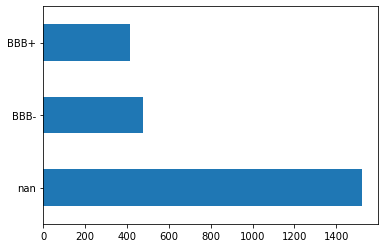

In [7]:
fig, ax = plt.subplots()
prox_knowledge['BBB+/BBB-'].value_counts(dropna=False).plot(kind='barh', ax=ax)
attila_utils.savefig(fig, 'bbb-barplot-chembl-screen')

['named-figure/bbb-barplot-chembl-screen-confidence-groups.png',
 'named-figure/bbb-barplot-chembl-screen-confidence-groups.pdf']

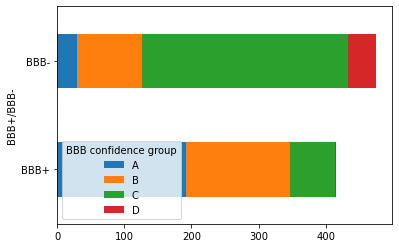

In [8]:
fig, ax = plt.subplots()
vc = prox_knowledge[['BBB+/BBB-', 'BBB confidence group']].value_counts()
vc = pd.concat([vc.index.to_frame(), vc.to_frame(name='count')], axis=1)
vc = vc.pivot(index='BBB+/BBB-', columns='BBB confidence group', values='count')
vc.plot(kind='barh', stacked=True, ax=ax)
attila_utils.savefig(fig, 'bbb-barplot-chembl-screen-confidence-groups')

Explanation of confidence groups.  See article [here](https://www.nature.com/articles/s41597-021-01069-5)

*    Group A: Molecules with numerical data. Several threshold values for log BB have been used to determine if a molecule is BBB permeable or not, including 0, 0.1, −1, (−2, 1). The value of −1 is chosen as the threshold value to define if a compound is BBB+ or BBB− since this is the mostly widely used threshold and maximizes the ease of comparison with other studies.
*    Group B: Molecules from sources that use log BB = −1 as the threshold value, and where all sources agree on the categorical label. The unambiguous label is used.
*    Group C: Molecules where all sources agree on the categorical label, but the sources that do not report their threshold value.
*    Group D: Molecules with two different BBB permeability labels. The most prevalent label is used. In the 45 cases where the two labels occurred with equal frequency, the molecule was discarded.

## Slightly different results under v2 of the drug-target network

v2 of the drug-target network comes with the extension of targets by drug mechanism.  This section shows that the extension did change the drug-target network, although this affects the results only slightly.  Still, for reproducibility v1 should be used for proximity calculations and v2 only for post-hoc analysis.

<AxesSubplot:xlabel='rank', ylabel='delta z'>

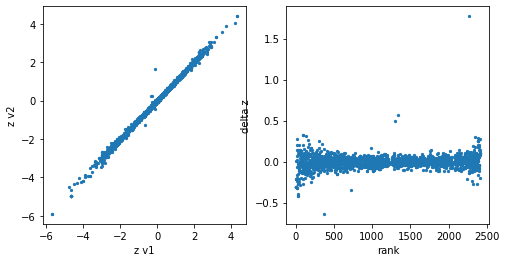

In [9]:
prox_knowledge_v2['z v1'] = prox_knowledge[['z']]
prox_knowledge_v2 = prox_knowledge_v2.rename({'z': 'z v2'}, axis=1)
prox_knowledge_v2['delta z'] = prox_knowledge_v2['z v2'] - prox_knowledge_v2['z v1']
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
prox_knowledge_v2.plot(kind='scatter', x='z v1', y='z v2', marker='.', ax=ax[0])
prox_knowledge_v2.plot(kind='scatter', x='rank', y='delta z', marker='.', ax=ax[1])

## Indications

In [10]:
def get_indication4screen(ont_id='mesh_id', ont_name='mesh_heading', screendf=prox_knowledge):
    fpath = '../../results/2021-12-13-chembl-drug-info/drug-indication.csv'
    df = pd.read_csv(fpath, usecols=['drug_chembl_id', 'drug_name', ont_id, ont_name], index_col=['drug_chembl_id', ont_id])
    df = df.drop_duplicates()
    chembl_ids2drop = set(df.index.get_level_values(0)).difference(set(screendf.index))
    df = df.drop(chembl_ids2drop, axis=0, level=0)
    return(df)

mesh_screen = get_indication4screen(ont_id='mesh_id', ont_name='mesh_heading')
mesh_screen.describe()

,drug_name,mesh_heading
count,22603,22259
unique,2399,1547
top,DEXAMETHASONE,Neoplasms
freq,235,433


In [11]:
efo_screen = get_indication4screen(ont_id='efo_id', ont_name='efo_term')
efo_screen.describe()

,drug_name,efo_term
count,24472,24091
unique,2399,1805
top,DEXAMETHASONE,neoplasm
freq,266,357


In [12]:
def indication_frequency(ind_df=mesh_screen):
    ind_counts = ind_df.value_counts(ind_df.index.names[1])
    ind_df = ind_df.droplevel('drug_chembl_id', axis=0).drop('drug_name', axis=1).drop_duplicates()
    val = pd.concat([ind_counts.to_frame('frequency'), ind_df], axis=1).dropna().astype({'frequency': np.int64})
    val['rank'] = np.arange(len(val)) + 1
    return(val)

mesh_freq = indication_frequency(ind_df=mesh_screen)
efo_freq = indication_frequency(ind_df=efo_screen)

['named-figure/mesh-efo-frequencies.png',
 'named-figure/mesh-efo-frequencies.pdf']

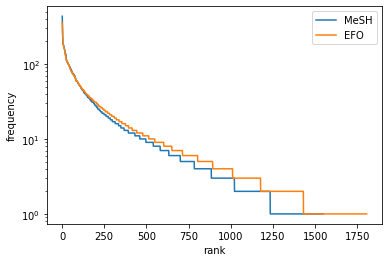

In [18]:
fig, ax = plt.subplots()
mesh_freq.plot('rank', 'frequency', ax=ax, label='MeSH')
efo_freq.plot('rank', 'frequency', ax=ax, label='EFO')
ax.set_yscale('log')
ax.set_ylabel('frequency')
attila_utils.savefig(fig, 'mesh-efo-frequencies')

In [14]:
mesh_freq.loc[mesh_freq.frequency >= 100]

,frequency,mesh_heading,rank
mesh_id,,,
D009369,433,Neoplasms,1
D001943,324,Breast Neoplasms,2
D064129,221,"Prostatic Neoplasms, Castration-Resistant",3
D002289,215,"Carcinoma, Non-Small-Cell Lung",4
D003866,183,Depressive Disorder,5
D002318,182,Cardiovascular Diseases,6
D010146,182,Pain,7
D008545,179,Melanoma,8
D008223,178,Lymphoma,9


In [15]:
efo_freq.loc[efo_freq.frequency >= 100]

,frequency,efo_term,rank
efo_id,,,
EFO:0000616,357,neoplasm,1
MONDO:0007254,300,breast cancer,2
EFO:0000311,263,cancer,3
MONDO:0008315,221,prostate cancer,4
EFO:0003060,215,non-small cell lung carcinoma,5
EFO:0003843,183,pain,6
EFO:0000319,182,cardiovascular disease,7
EFO:0000574,178,lymphoma,8
EFO:0001378,173,multiple myeloma,9


In [16]:
%connect_info

{
  "shell_port": 51757,
  "iopub_port": 51758,
  "stdin_port": 51759,
  "control_port": 51761,
  "hb_port": 51760,
  "ip": "127.0.0.1",
  "key": "a9e60f2b-96b86be41dbc7a2fbebbc6df",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-52dd31ec-f7c9-4a7a-add5-62cee6f88582.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
